# Generate mock dataset

In this notebook, we create a mock *Gaia* DR3 dataset consisting of a stellar stream aound its progenitor GC and background stars.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.coordinates as coord
import agama

from StarStream import calc_prog_frame, spray, assign_color_mag, sig_pm_from_G_gdr3, sig_color_from_G_gdr3

# isochrones is just for this notebook, not the package
from isochrones.mist import MIST_Isochrone 
mist = MIST_Isochrone()

Holoviews not imported. Some visualizations will not be available.
PyMultiNest not imported.  MultiNest fits will not work.


## Spatial and magnitude ranges to find streams

In [2]:
field_range = (-10.0, 10.0) # spatial range in deg
mag_cut = 20.0 # magnitude cut
mag_range = (15.0, mag_cut) # magnitude range

## Parameters of the toy Galaxy and GC

In [3]:
pot = agama.Potential("data/MWPotential2014.ini")

mass_gc = 1e5 # Msun
coord_gc = coord.Galactocentric(
    x=0.0*u.kpc,
    y=10.0*u.kpc,
    z=10.0*u.kpc,
    v_x=-100.0*u.km/u.s,
    v_y=0.0*u.km/u.s,
    v_z=-150.0*u.km/u.s
)
age = 10.0 # Gyr
feh = -1.0

skycoord_gc = coord_gc.transform_to(coord.ICRS())
frame = calc_prog_frame(skycoord_gc)

iso = mist.isochrone(age=age, feh=feh) # if you never run this before, it'll take a while
iso_mini = iso["initial_mass"]
iso_color = iso["BP_mag"] - iso["RP_mag"]
iso_mag = iso["G_mag"]

## Let's generate the mock dataset

The mock data is a combination of stream + background. Although the two are generated seperately here, they should come together in reality.

### Mock stream

Here, mock stream is generated using some convenient functions provided by StarStream.

In [4]:
t_tot = 1.0 # Gyr
n_steps = 200
pot_gc = agama.Potential(type="Plummer", mass=mass_gc, scaleRadius=4e-3)
nhalf_release = None # None means uniform rate
seed = 42

coord_stream, t_stream = spray(pot=pot, mass_gc=mass_gc, coord_gc=coord_gc, t_tot=t_tot, n_steps=n_steps, pot_gc=pot_gc, nhalf_release=nhalf_release, seed=seed)

phi1phi2_stream = coord_stream.transform_to(frame())

# Assign color and mag to stream stars

mag_stream, color_stream = assign_color_mag(
    phi1phi2_stream.distance.to_value("kpc"), mag_cut, iso_mini, iso_color, iso_mag, seed=seed
)

mask = mag_stream < mag_cut
mag_stream, color_stream, phi1phi2_stream = mag_stream[mask], color_stream[mask], phi1phi2_stream[mask]

398 orbits complete (9045 orbits/s)


In [5]:
# the final datasets are multi-dimensional arrays

data_stream = np.c_[
    phi1phi2_stream.phi1.wrap_at(180*u.deg).to_value("deg"),
    phi1phi2_stream.phi2.to_value("deg"),
    phi1phi2_stream.pm_phi1_cosphi2.to_value("mas/yr"),
    phi1phi2_stream.pm_phi2.to_value("mas/yr"),
    color_stream,
    mag_stream
]

# add error to mock stream

err_stream = np.c_[
    np.zeros_like(mag_stream),
    np.zeros_like(mag_stream),
    sig_pm_from_G_gdr3(mag_stream),
    sig_pm_from_G_gdr3(mag_stream),
    sig_color_from_G_gdr3(mag_stream),
    np.zeros_like(mag_stream),
]

rng = np.random.default_rng(seed)
data_stream += rng.normal(loc=0, scale=err_stream)

label_stream = np.ones_like(mag_stream, dtype=bool)

### Let's visualize how the stream looks like in various parameter spaces

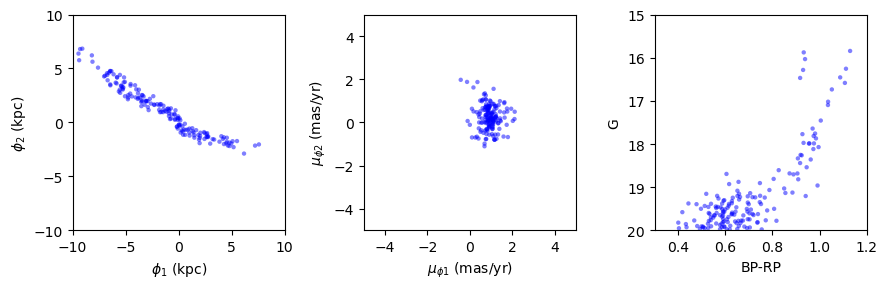

In [6]:
fig, [ax0, ax1, ax2] = plt.subplots(1, 3, figsize=(9,3))

ax0.scatter(data_stream[:,0], data_stream[:,1], fc="b", ec="None", s=10, alpha=0.5)
ax1.scatter(data_stream[:,2], data_stream[:,3], fc="b", ec="None", s=10, alpha=0.5)
ax2.scatter(data_stream[:,4], data_stream[:,5], fc="b", ec="None", s=10, alpha=0.5)

ax0.set_xlabel(r"$\phi_1$ (kpc)")
ax0.set_ylabel(r"$\phi_2$ (kpc)")
ax1.set_xlabel(r"$\mu_{\phi1}$ (mas/yr)")
ax1.set_ylabel(r"$\mu_{\phi2}$ (mas/yr)")
ax2.set_xlabel(r"BP-RP")
ax2.set_ylabel(r"G")

ax0.set_xlim(*field_range)
ax0.set_ylim(*field_range)
ax1.set_xlim(-5.0,5.0)
ax1.set_ylim(-5.0,5.0)
ax2.set_xlim(0.3,1.2)
ax2.set_ylim(mag_range[1],mag_range[0])

plt.tight_layout()
plt.show()

### Mock background

In [7]:
# gather data into arrays

N_bg = int(1e5)

data_bg = np.c_[
    rng.uniform(low=field_range[0], high=field_range[1], size=N_bg),
    rng.uniform(low=field_range[0], high=field_range[1], size=N_bg),
    rng.normal(loc=0.0, scale=2.0, size=N_bg),
    rng.normal(loc=0.0, scale=2.0, size=N_bg),
    rng.normal(loc=1.0, scale=0.2, size=N_bg),
    rng.uniform(low=mag_range[0], high=mag_range[1], size=N_bg)
]

# error array
# background already includes error, no need to add

mag_bg = data_bg[:,5]

err_bg = np.c_[
    np.zeros(N_bg),
    np.zeros(N_bg),
    sig_pm_from_G_gdr3(mag_bg),
    sig_pm_from_G_gdr3(mag_bg),
    sig_color_from_G_gdr3(mag_bg),
    np.zeros(N_bg),
]

label_bg = np.zeros(N_bg, dtype=bool)

### combine mock stream and background

In [8]:
data_all = np.r_[data_stream, data_bg]
err_all = np.r_[err_stream, err_bg]
label_all = np.r_[label_stream, label_bg]

### Let's visualize how the entire mock dataset looks like in various parameter spaces

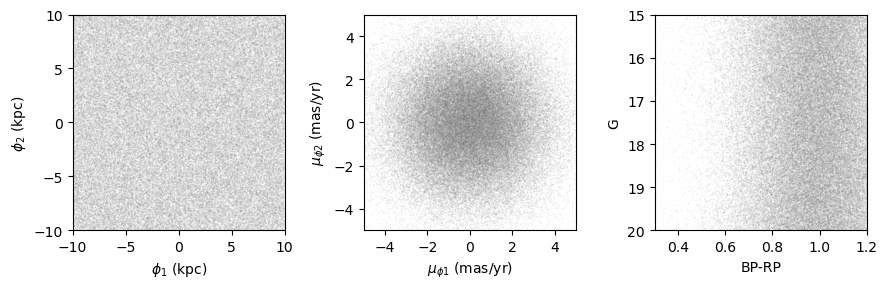

In [9]:
fig, [ax0, ax1, ax2] = plt.subplots(1, 3, figsize=(9,3))

ax0.scatter(data_all[:,0], data_all[:,1], fc="gray", ec="None", s=1, alpha=0.1)
ax1.scatter(data_all[:,2], data_all[:,3], fc="gray", ec="None", s=1, alpha=0.1)
ax2.scatter(data_all[:,4], data_all[:,5], fc="gray", ec="None", s=1, alpha=0.1)

ax0.set_xlabel(r"$\phi_1$ (kpc)")
ax0.set_ylabel(r"$\phi_2$ (kpc)")
ax1.set_xlabel(r"$\mu_{\phi1}$ (mas/yr)")
ax1.set_ylabel(r"$\mu_{\phi2}$ (mas/yr)")
ax2.set_xlabel(r"BP-RP")
ax2.set_ylabel(r"G")

ax0.set_xlim(*field_range)
ax0.set_ylim(*field_range)
ax1.set_xlim(-5.0,5.0)
ax1.set_ylim(-5.0,5.0)
ax2.set_xlim(0.3,1.2)
ax2.set_ylim(mag_range[1],mag_range[0])

plt.tight_layout()
plt.show()

Looks like the background is pretty strong. It's almost impossible to find the stream by eyes.

## Save data

In [10]:
np.savetxt("data/mock_dataset.txt", np.c_[data_all, err_all, label_all], fmt="%.6f "*12+"%d")